In [1]:
%matplotlib inline
import pykat
import pylab as pl
import numpy as np

### My functions
from kat_commands import *
from cav_commands import *
from MMT import modematch

import get_WS
import trace_mode

                                              ..-
    PyKat 1.0.17          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat"
maxtem = 2  

In [3]:
#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands)
basekat.parseCommands(add_squeezing)
basekat.parseCommands(cav_commands_FC_last)
basekat.parseCommands("maxtem "+str(maxtem))
basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

In [4]:
#perfect mode matching no squeezing for a reference
basekat0 = pykat.finesse.kat() 
basekat0.loadKatFile(katfile)
basekat0.parseCommands(darm_commands)
basekat0.parseCommands(cav_commands_FC_last)
basekat0.parseCommands("maxtem "+str(maxtem))
basekat0.undumpNodes() #undump the vacuum nodes
kat0=basekat0.deepcopy() #copy kat code
kat0.verbose = False

out_perfect_mm_nosqz = kat0.run()

In [17]:
###
###Extract the eigenmode of SRC with offsets in SR3
###
SR3_Rc_orig = kat.SR3.Rc.value
max_offset_SR3 = .01634 #95% Roc change in SR3 curvature

#Add Commands
basekat1 = pykat.finesse.kat() 
basekat1.loadKatFile(katfile)
basekat1.parseCommands(commands)
basekat1.parseCommands(cav_commands_FC_last)
basekat1.parseCommands(amplitude_detectors)
basekat1.parseCommands(pds)
kat1=basekat1.deepcopy() 
kat1.verbose = False

# Change the SR3_HR RoC
SR3_Rc_new = SR3_Rc_orig + max_offset_SR3
kat1.SR3.Rcx.value = SR3_Rc_new
kat1.SR3.Rcy.value = SR3_Rc_new

#Run and extract the q's at the OFI and SRMHR
out_new_SR3_roc = kat1.run()

#### Extract the mode at the SRMAR w.r.t the ARM
[get_SRM_qx_wrt_cavARM,get_SRM_qy_wrt_cavARM] = trace_mode.from_cav_to_node(kat1,'cavXARM','nSRMARb')

#### Extract the mode at the OFI w.r.t the OMC
[get_OFI_qx_wrt_OMC,get_OFI_qy_wrt_OMC] = trace_mode.from_cav_to_node(kat1,'cavOMC','nIBAin')

q_refin_x = get_SRM_qx_wrt_cavARM
q_refin_y = get_SRM_qy_wrt_cavARM

q_refout_x = get_OFI_qx_wrt_OMC
q_refout_y = get_OFI_qy_wrt_OMC

################## Implement the telescope to MM the ARMS to OMC while changing SRC
basekat1 = pykat.finesse.kat() 
basekat1.loadKatFile(katfile)
basekat1.parseCommands(darm_commands)
basekat1.parseCommands(amplitude_detectors)
basekat1.parseCommands(add_squeezing)
basekat1.parseCommands(cav_commands_FC_last)
#basekat1.parseCommands("maxtem "+str(maxtem))
basekat1.parseCommands("maxtem 4")
basekat1.parseCommands("""
bp q_sqz_x x q nsqz
bp q_sqz_y y q nsqz
""")
basekat1.undumpNodes()
kat1=basekat1.deepcopy()
kat1.verbose = False
    
SR3_Rc = kat.SR3.Rc
dRc = max_offset_SR3
    
kat1.SR3.Rcx.value = SR3_Rc + dRc
kat1.SR3.Rcy.value = SR3_Rc + dRc

#
#    q1   d1   f1  d2   f2  d3   q2
#    |   <-->  |  <-->  | <-->  |
#    | <---------- D ---------> |
#

q1 = q_refin_x
q2 = -np.conjugate(q_refout_x)
D  = 0.491516 # total distance from SRC to OFI
d1 = 0.25
d2 = 0.0001
d3 = D-d1-d2

[f1, f2] = modematch(q1, q2, d1, d2, d3)

kat1.lSRMTT1.L.value = d1
kat1.SRMTT1.f.value = f1
kat1.lSRMTT2.L.value = d2
kat1.SRMTT2.f.value = f2
kat1.lIBAin.L.value = d3

# Get the q at the sqzer
out_varySR3 = kat1.run()

Successfully Mode-Matched! >99.9% overlap
f1 is 0.001495753375465786
f2 is -0.001395706688821341


In [18]:
##### Testing to trace the modes

### q from the output of the simulation
q_sqz_x = out_varySR3["q_sqz_x"][0]
q_sqz_y = out_varySR3["q_sqz_y"][0]

#### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
[srcx,srcy] = trace_mode.from_cav_to_BS(kat1,'cavSRY')

#### Turn off all the cav commands except XARM to extract the eigenmode at the BS
[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat1,'cavXARM')

#### Turn off all the cav commands except OMC to extract the eigenmode at the BS
[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat1,'cavOMC')

#### Turn off all the cav commands except FC to extract the eigenmode at the BS
[FCx,FCy] = trace_mode.from_cav_to_BS(kat1,'cavFC')

#### Turn off all the cav commands except SRCY to extract the eigenmode at the Sqz
[get_nsqz_qx_wrt_SRC,get_nsqz_qy_wrt_SRC] = trace_mode.from_cav_to_node(kat1,'cavSRY','nsqz')

#### Turn off all the cav commands except XARM to extract the eigenmode at the Sqz
[get_nsqz_qx_wrt_ARM,get_nsqz_qy_wrt_ARM] = trace_mode.from_cav_to_node(kat1,'cavXARM','nsqz')

#### Turn off all the cav commands except OMC to extract the eigenmode at the Sqz
[get_nsqz_qx_wrt_OMC,get_nsqz_qy_wrt_OMC] = trace_mode.from_cav_to_node(kat1,'cavOMC','nsqz')

#### Turn off all the cav commands except OMC to extract the eigenmode at the Sqz
[get_nsqz_qx_wrt_FC,get_nsqz_qy_wrt_FC] = trace_mode.from_cav_to_node(kat1,'cavFC','nsqz')

In [20]:
### Compare the squeezing node by swapping FC around in order


In [21]:
### Scan the FC Cavity


/home/thomasvo/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


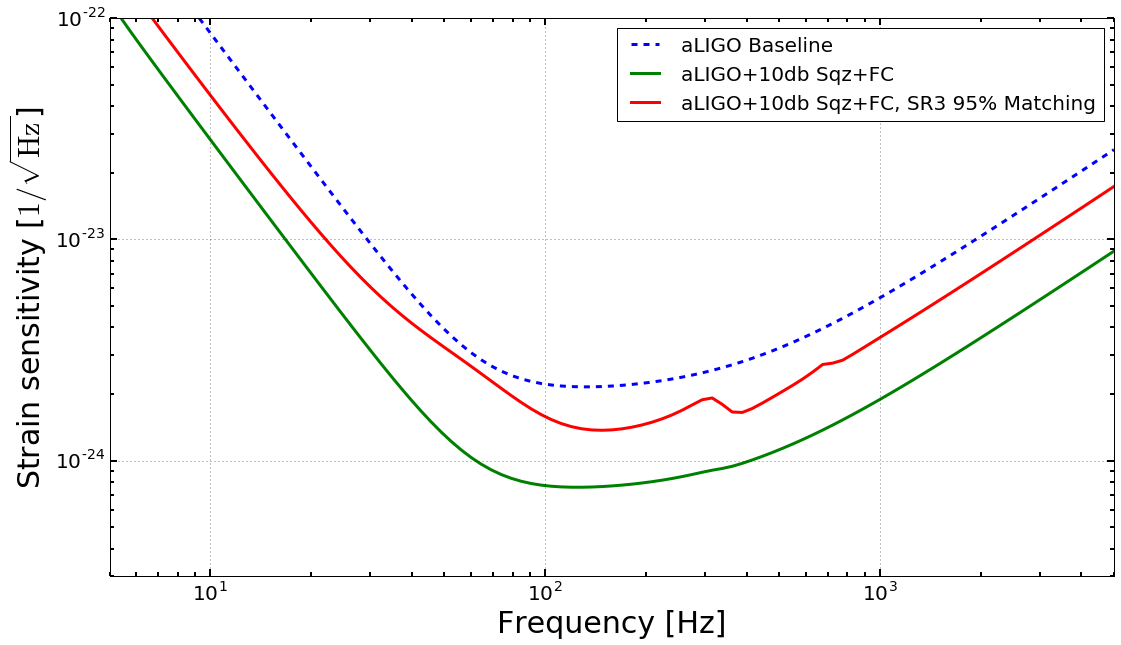

In [22]:
pl.figure(figsize=(18, 10), dpi=80)
pl.subplot(111)

pl.loglog(out_perfect_mm.x, out_perfect_mm_nosqz['NSR_with_RP'],'--',linewidth=3, label='aLIGO Baseline')
pl.loglog(out_perfect_mm.x, out_perfect_mm['NSR_with_RP'],linewidth=3, label='aLIGO+10db Sqz+FC')

pl.loglog(out_varySR3.x, out_varySR3['NSR_with_RP'],linewidth=3, label='aLIGO+10db Sqz+FC, SR3 95% Matching')

pl.xlim(out_perfect_mm.x.min(),out_perfect_mm.x.max())
pl.ylim(3e-25,1e-22)

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.show()